# ML Case  Study

### Goals

   - Code churn
      - Convert trips in last 30 to date time (Done)
      - booleanify (Done)
   - Dummify cities (Done)
   - Dummify phone type (Done)
   - Determine which columns are likely to be predictive
       - lmplots conditioned on churn
       - categorical means by churn 
         - Clearly phone and city are important for churn rate
           - significantly so?
           - Why?
   - Handle class imbalance
       - 62% churn - likely not important
   
### Model building

Define goals: Prediction or interpretation
 
 - Choose model type

     - Has feature importance 
       - Random forest
     - interpretable coefficients?
       - logistic regression
  - Create different models by city or by phone type
    - Try to understand why there are such big differences in the cities and phones
     

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [140]:

df = pd.read_csv('data/churn.csv')


# Data Cleaning

In [141]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)

# Add churn column
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date) / np.timedelta64(1, 'D')
df['churn'] = (df['days_since_last_trip'] > 30)

# Days since signup
df.signup_date = pd.to_datetime(df.signup_date)
df['days_since_signup'] = (df.last_trip_date.max() - df.signup_date) / np.timedelta64(1, 'D')

In [142]:
df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn,days_since_signup
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,False,157
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,True,153
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,True,176
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,False,172
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,True,155


# Plots Conditioned by Churn

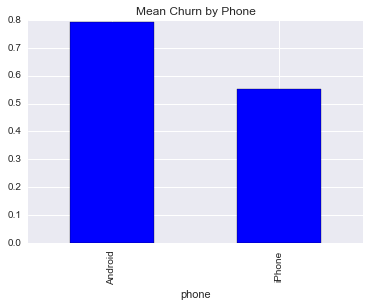

In [143]:
df['phone'] = np.where(df.phone.isnull(), "iPhone", df.phone)
df.groupby('phone').churn.mean().plot(kind="bar")
plt.title("Mean Churn by Phone");

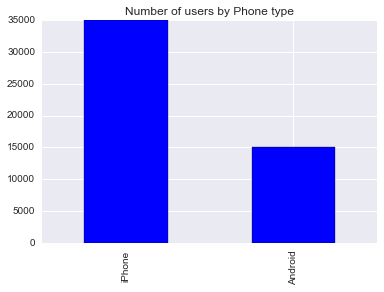

In [144]:
df['phone'].value_counts().plot(kind="bar")
plt.title("Number of users by Phone type")

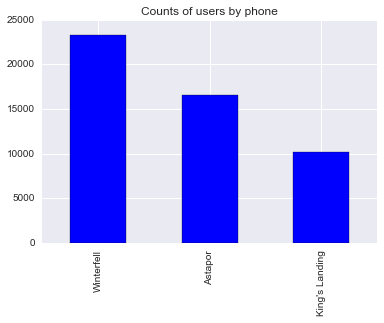

In [145]:
df['city'].value_counts().plot(kind="bar")
plt.title("Counts of users by phone");


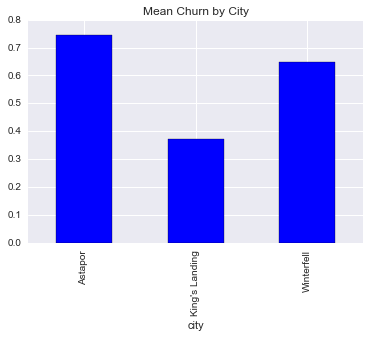

In [146]:
df.groupby('city').churn.mean().plot(kind="bar")
plt.title("Mean Churn by City");

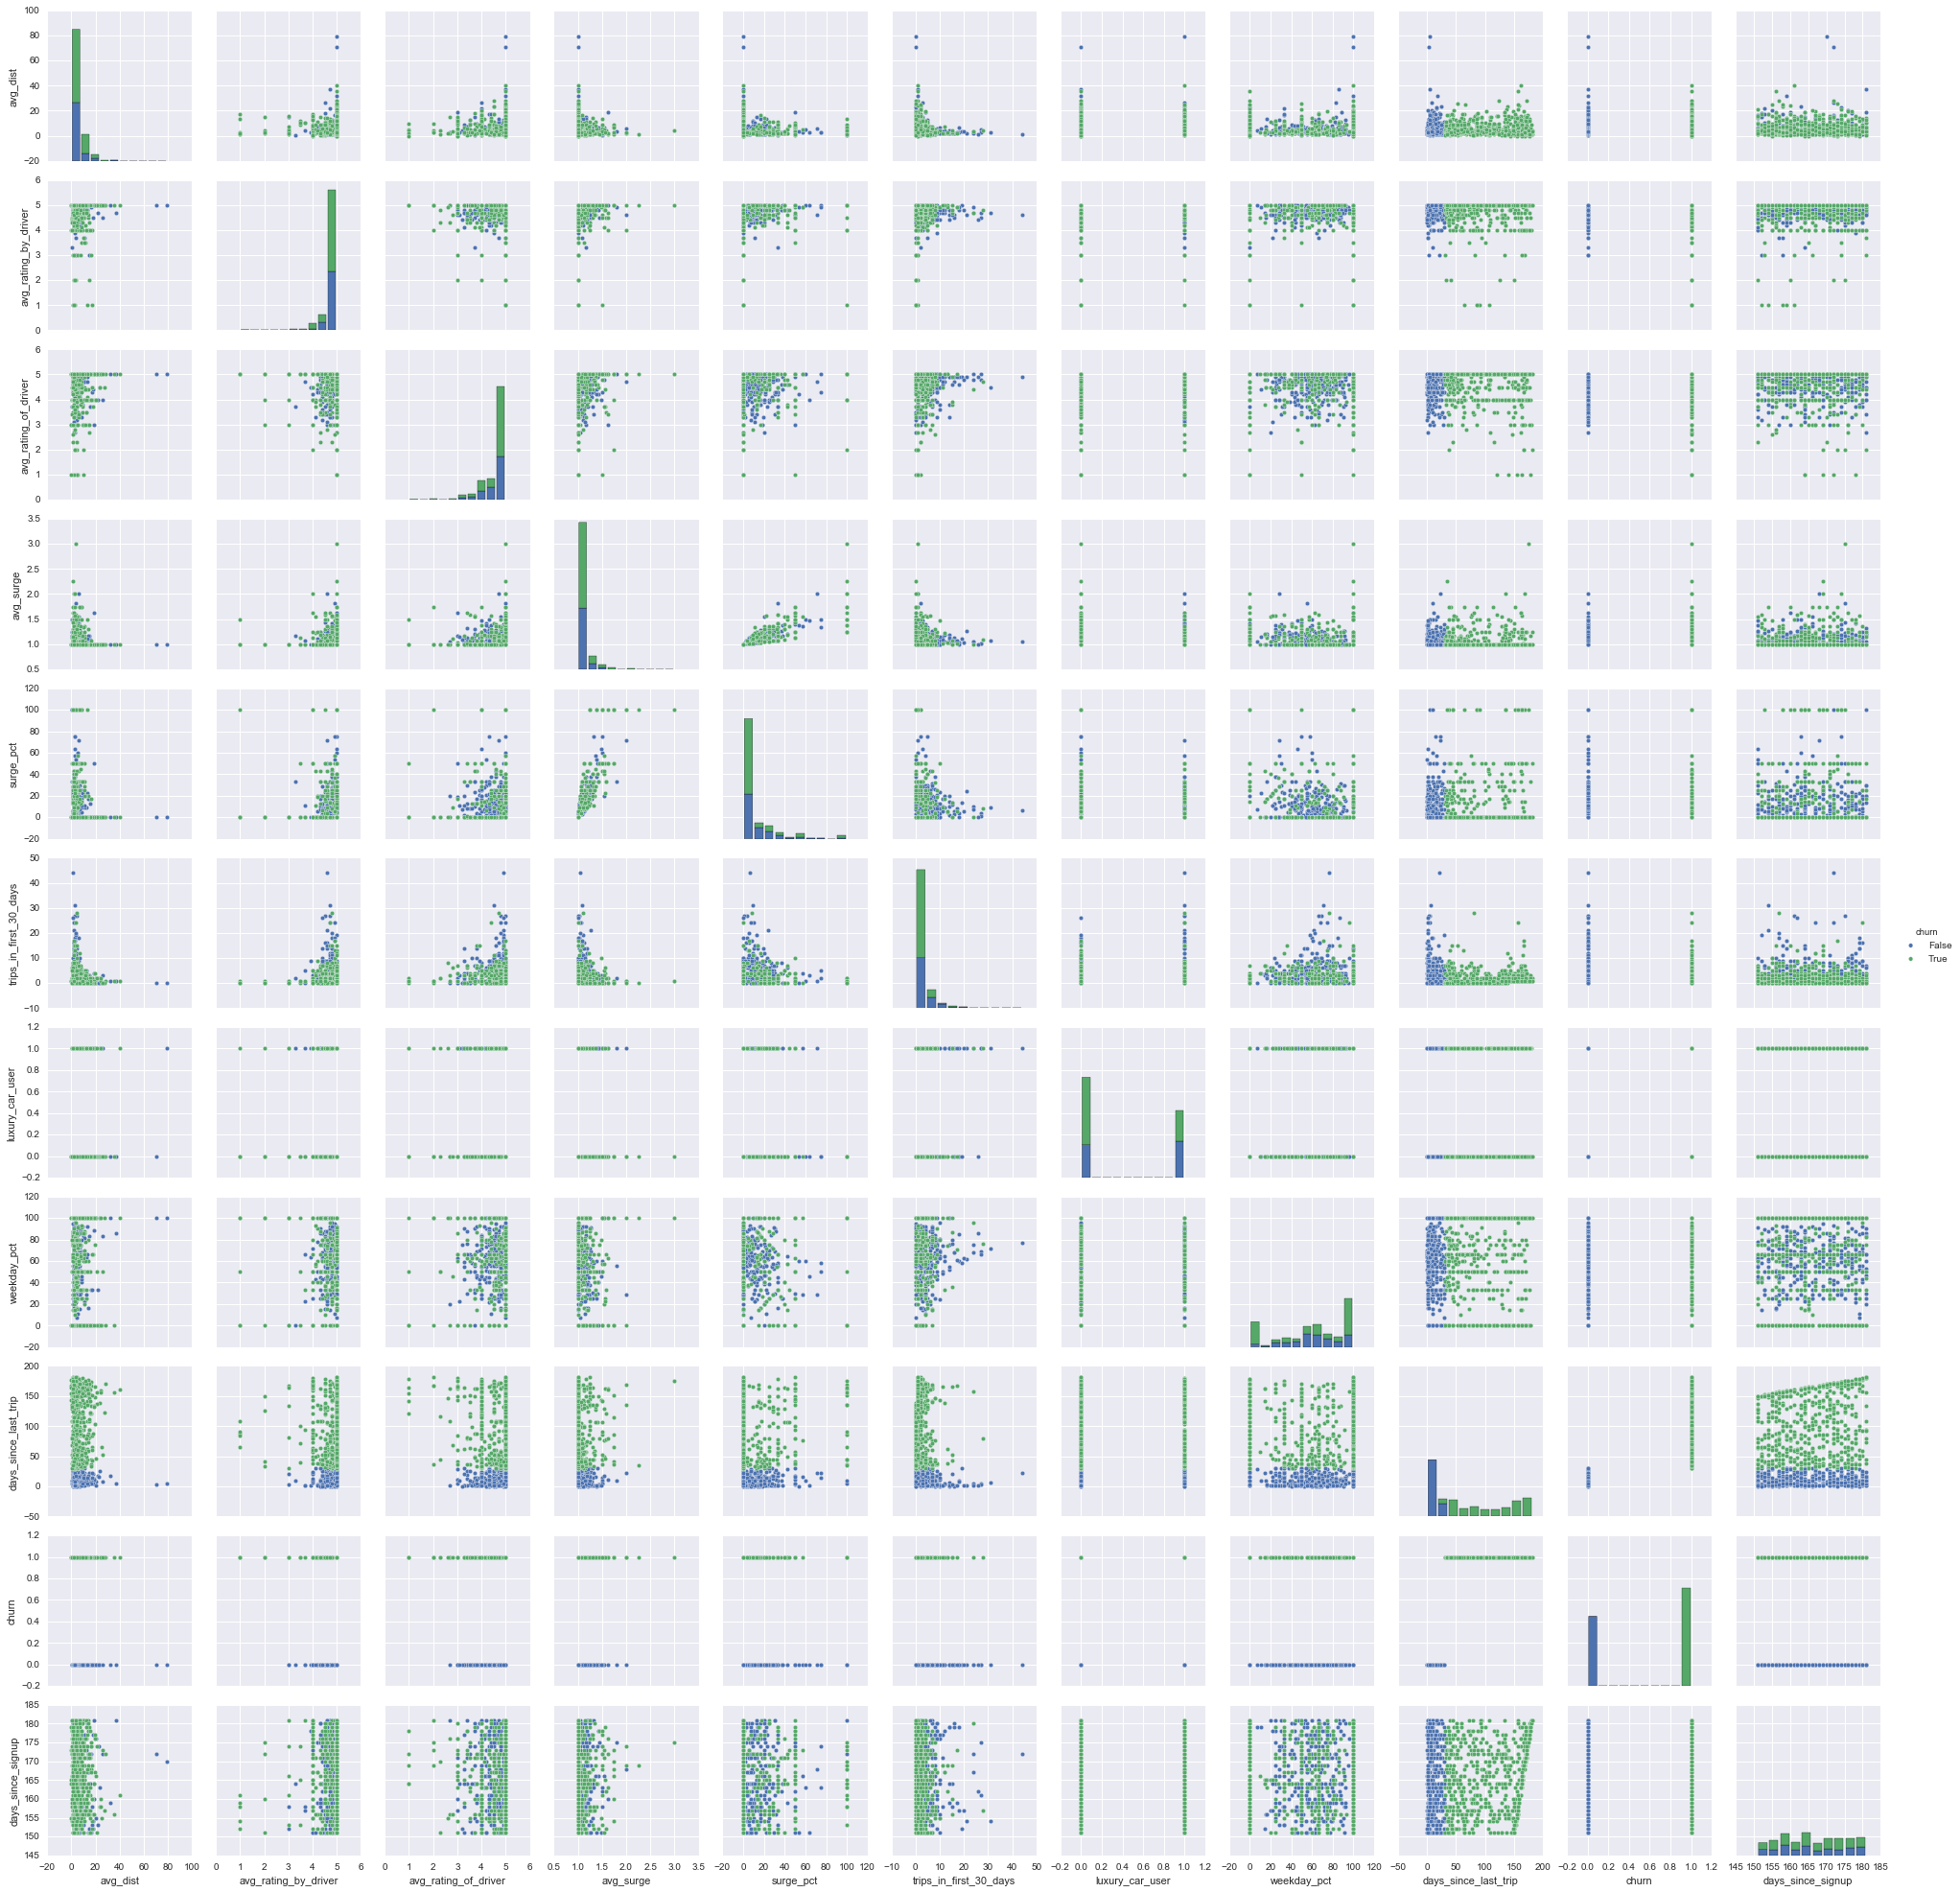

In [147]:
sns.pairplot(df.dropna().sample(1000)[[col for col in df.columns if col not in ['city', 'phone']]], hue="churn")

# Dummyifying Variables


In [148]:
df['isAndroid'] = np.where(df['phone'] == "Android", True, False)
df.drop('phone', axis=1, inplace=True)

df_city = pd.get_dummies(df['city'])
frames = [df, df_city]
df = pd.concat(frames, axis=1)
df = df.drop('city', axis=1)

In [149]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn,days_since_signup,isAndroid,Astapor,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,14,False,157,False,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,57,True,153,True,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,175,True,176,False,1,0,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,2,False,172,False,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,108,True,155,True,0,0,1


# Investigating Average Surge effect on Churn

In [150]:
df.groupby('churn').avg_surge.describe()

churn       
False  count    18804.000000
       mean         1.073809
       std          0.163170
       min          1.000000
       25%          1.000000
       50%          1.000000
       75%          1.090000
       max          4.500000
True   count    31196.000000
       mean         1.075339
       std          0.251361
       min          1.000000
       25%          1.000000
       50%          1.000000
       75%          1.000000
       max          8.000000
dtype: float64

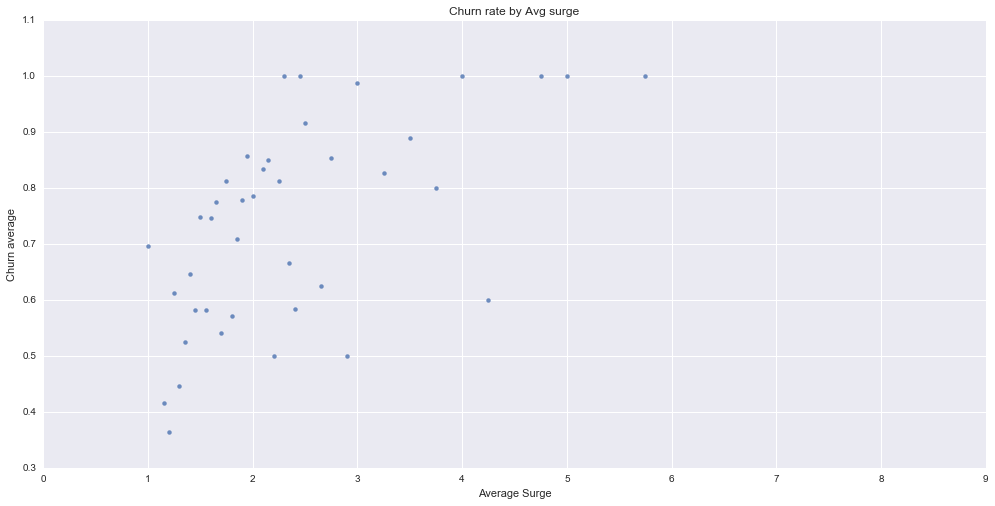

In [151]:
epsilon = 0.025
avg_churn = []
avg_surge = []
num_obs = []
for avg in np.arange(1,8,epsilon*2):
    
    avg_churn.append(df[(df.avg_surge < avg + epsilon) & (df.avg_surge > avg - epsilon)].churn.mean())
    num_obs.append(df[(df.avg_surge < avg + epsilon) & (df.avg_surge > avg - epsilon)].shape[0])
    avg_surge.append(avg)

ch_vs_surge = pd.DataFrame(zip(avg_surge, avg_churn, num_obs)).rename(columns={0:"avg_surge", 1:"avg_churn", 2:'num_obs'})

sns.lmplot(x='avg_surge', y='avg_churn', data=ch_vs_surge, fit_reg=False, size=7, aspect=2)
plt.title("Churn rate by Avg surge")
plt.xlabel("Average Surge")
plt.ylabel("Churn average")
plt.ylim(0.3,1.1);

# Pairwise t-tests for categoricals

In [152]:
from scipy.stats import ttest_ind
t_tests = {'Android-iPhone':"(statistic=56.177771317354384, pvalue=0.0)","Astapor-King's Landing":"(statistic=63.338256512763827, pvalue=0.0)",
         'Astapor-Winterfell':"(statistic=20.857565532357761, pvalue=4.5904054869968492e-96)",
          "King's Landing-Winterfell":"(statistic=-48.199064350367962, pvalue=0.0)",
          'luxury-not luxury':"(statistic=-45.830427267725014, pvalue=0.0)"}
t_tests

{'Android-iPhone': '(statistic=56.177771317354384, pvalue=0.0)',
 "Astapor-King's Landing": '(statistic=63.338256512763827, pvalue=0.0)',
 'Astapor-Winterfell': '(statistic=20.857565532357761, pvalue=4.5904054869968492e-96)',
 "King's Landing-Winterfell": '(statistic=-48.199064350367962, pvalue=0.0)',
 'luxury-not luxury': '(statistic=-45.830427267725014, pvalue=0.0)'}

# Logistic Regression

In [164]:
df = df.dropna()
y = df['churn']
col=['avg_dist', 'avg_surge', 'surge_pct', 'Astapor', "King's Landing", "Winterfell",
      'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct', 'avg_rating_of_driver', 'avg_rating_by_driver',
      'isAndroid', 'days_since_signup']
X = df[col].dropna()

X.head()

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.70414940414556682

In [165]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)

logit_coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_).squeeze())).\
    rename(columns = {0:'Variable', 1:'LogOdds'})
    
logit_coefs['OddsRatio'] = np.exp(logit_coefs.LogOdds)

logit_coefs.sort_values('OddsRatio', ascending=False)



,Variable,LogOdds,OddsRatio
11,isAndroid,1.109987,3.034318
3,Astapor,0.730762,2.076662
5,Winterfell,0.217095,1.242462
10,avg_rating_by_driver,0.195298,1.215673
1,avg_surge,0.111784,1.118271
9,avg_rating_of_driver,0.058132,1.059855
0,avg_dist,0.036837,1.037524
8,weekday_pct,-0.000094,0.999906
2,surge_pct,-0.003189,0.996816
12,days_since_signup,-0.005552,0.994464


In [166]:
log_model.get_params

<bound method LogisticRegression.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [ ]:
sum(model.predict(X_test) == y_test)/float(len(y_test))

## Insights:

Android users have 3 times the odds of churning than do iPhone users, all other things held constant

# Random Forest

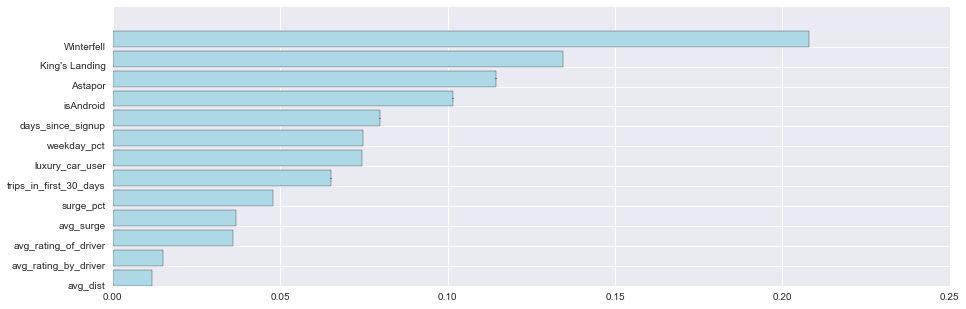

In [16]:
from sklearn.ensemble import RandomForestClassifier
df_xgb = df.drop(['signup_date', 'last_trip_date', 'days_since_last_trip'], axis=1).copy()
y = df_xgb.pop('churn').values

df_xgb.avg_rating_by_driver = df_xgb.avg_rating_by_driver.fillna(df_xgb.avg_rating_by_driver.mean())
df_xgb.avg_rating_of_driver = df_xgb.avg_rating_of_driver.fillna(df_xgb.avg_rating_of_driver.mean())
X = df_xgb.values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=8, test_size=.2)
rf = RandomForestClassifier().fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
            axis=0)
indices = np.argsort(importances)
plt.figure(figsize=(15,5))
plt.barh(range(len(indices)), importances[indices], yerr=std[indices], color='lightblue')
ticks = plt.yticks(range(len(indices)), df_xgb.columns)


# XGBoost

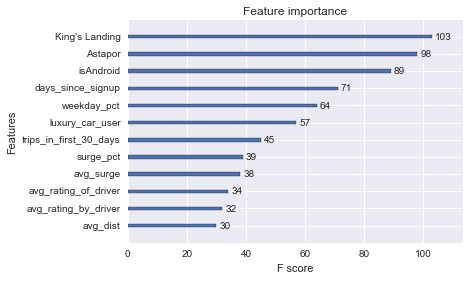

In [17]:
import xgboost
gbm = xgboost.XGBClassifier(silent=False, seed=8).fit(X_train, y_train)
plot = xgboost.plot_importance(gbm)
ticks = plot.set_yticklabels(df_xgb.columns)


In [18]:
df_xgb['churn']=y

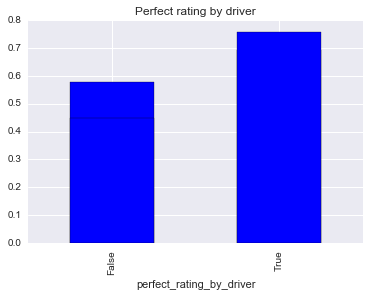

In [19]:

df_xgb['perfect_rating_of_driver'] = (df_xgb.avg_rating_of_driver == 5)
df_xgb.groupby('perfect_rating_of_driver').mean().churn.plot(kind='bar')
plt.title('Perfect rating of driver')

df_xgb['perfect_rating_by_driver'] = (df_xgb.avg_rating_by_driver == 5)
df_xgb.groupby('perfect_rating_by_driver').mean().churn.plot(kind='bar')
plt.title('Perfect rating by driver')

### Models and Optimization

split training and test

  - ROC curves
  - Profit curve
    - Need to define cost and benefit
  
  - Random forest
    - depth, n_trees
  - XGBoost
    - n_estimators
  - KNN
    - N
  - SVM
    - bases
    - cost
    - gamma, degree, 
  - Logistic Regression
    - scaled
  - Play with regularization if we have time!
  
**optimize accuracy**

In [49]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

### Beginning form the same spot


In [20]:

df_origin = pd.read_csv('data/churn.csv')


# In[164]:

df = df_origin.copy()

df.last_trip_date = pd.to_datetime(df.last_trip_date)

df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date) / np.timedelta64(1, 'D')
df['churn'] = (df['days_since_last_trip'] > 30)

df.signup_date = pd.to_datetime(df.signup_date)
df['days_since_signup'] = (df.last_trip_date.max() - df.signup_date) / np.timedelta64(1, 'D')
df = df.drop(['days_since_last_trip', 'last_trip_date', 'signup_date'], axis=1)

df_phone = pd.get_dummies(df['phone'])
frames = [df, df_phone]
df = pd.concat(frames, axis=1)
df = df.drop(['phone', 'iPhone'], axis=1)

df_city = pd.get_dummies(df['city'])
frames = [df, df_city]
df = pd.concat(frames, axis=1)
df = df.drop('city', axis=1)
df = df.drop(['Winterfell'], axis=1).copy()

In [21]:
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
churn                     50000 non-null bool
days_since_signup         50000 non-null float64
Android                   50000 non-null float64
Astapor                   50000 non-null float64
King's Landing            50000 non-null float64
dtypes: bool(2), float64(10), int64(1)
memory usage: 4.7 MB


In [23]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
df_c = df.copy()
y_scale = df_c.pop('churn')
X = pd.DataFrame(StandardScaler().fit_transform(df_c))

In [25]:
X.columns = df_c.columns

# Splitting training and testing

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Logistic Regression for Ensemble

In [70]:


X_log = X_train.copy()
y_log = y_train.copy()

log_model = LogisticRegression()
log_model.fit(X_log, y_log)

logit_coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_).squeeze())).\
    rename(columns = {0:'Variable', 1:'LogOdds'})
    
logit_coefs['OddsRatio'] = np.exp(logit_coefs.LogOdds)

logit_coefs.sort_values('OddsRatio', ascending=False)

,Variable,LogOdds,OddsRatio
9,Android,0.495043,1.640569
10,Astapor,0.242777,1.274784
0,avg_dist,0.210257,1.233995
1,avg_rating_by_driver,0.069641,1.072123
3,avg_surge,0.043179,1.044125
2,avg_rating_of_driver,0.039763,1.040564
7,weekday_pct,0.012887,1.012970
8,days_since_signup,-0.056286,0.945269
4,surge_pct,-0.081041,0.922156
6,luxury_car_user,-0.425463,0.653467


In [72]:
sum(log_model.predict(X_test) == y_test)/float(len(y_test))

0.71160000000000001

# SVM for ensemble


In [38]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

### Radial Kernel

In [39]:
C_range =     [10**x for x in np.arange(-3,4,1)]
gamma_range = [10**x for x in np.arange(-3,4,1)]

params = {'C':     C_range,
          'gamma': gamma_range}

In [40]:
C_range

[0.001, 0.01, 0.10000000000000001, 1, 10, 100, 1000]

In [46]:
# Initialize the SVC model
Pysvm = SVC(kernel='rbf')

# Creaste a gridsearch object with our defined parameters
# the cv argument takes input k = folds
svmGS = GridSearchCV(Pysvm, params, scoring='accuracy', cv=3, n_jobs=-1)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_train, y_train, test_size=0.9, random_state=8)

In [47]:
svmGS.fit(X_train_svm, y_train_svm);

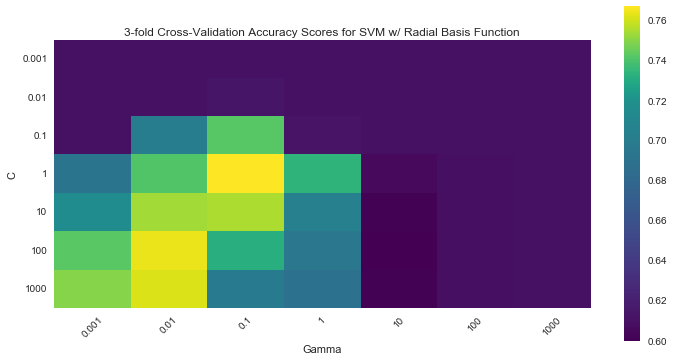

In [67]:
n_labs = 5
scores = [x[1] for x in svmGS.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(12,6) )
plt.imshow(scores,
           interpolation='nearest',
           cmap=plt.cm.viridis,
           norm=MidpointNormalize(vmin=0.6, midpoint=0.72),
           aspect = 0.5)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(0, len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(0, len(C_range)),  C_range)
plt.title('3-fold Cross-Validation Accuracy Scores for SVM w/ Radial Basis Function')
plt.grid(False)
plt.show()

Radial basis function SVM accuracy

In [73]:
sum(svmGS.predict(X_test_svm) == y_test_svm)/float(len(y_test_svm))


0.76047222222222222

In [86]:
svmGS.best_params_

{'C': 1, 'gamma': 0.10000000000000001}

### Linear Kernel


In [80]:
C_range =     [10**x for x in np.arange(-2,3,1)]
gamma_range = [10**x for x in np.arange(-2,3,1)]

params = {'C':     C_range,
          'gamma': gamma_range}
# Initialize the SVC model
Pysvm_lin = SVC(kernel='linear')

# Creaste a gridsearch object with our defined parameters
# the cv argument takes input k = folds
svmGS_lin = GridSearchCV(Pysvm_lin, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=3)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_train, y_train, test_size=0.95, random_state=8)

In [81]:
svmGS_lin.fit(X_train_svm, y_train_svm);

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.1min finished


[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ..................... C=0.01, gamma=0.01, score=0.709145 -   0.1s[CV] ..................... C=0.01, gamma=0.01, score=0.716642 -   0.1s

[CV] C=0.01, gamma=0.1 ...............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ...................... C=0.01, gamma=0.1, score=0.709145 -   0.1s[CV] ..................... C=0.01, gamma=0.01, score=0.701201 -   0.1s

[CV] C=0.01, gamma=1 .................................................
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ........................ C=0.01, gamma=1, score=0.709145 -   0.1s[CV] ...................... C=0.01, gamma=0.1, score=0.716642 -   0.1s

[CV] C=0.01, gamma=1 .................................................
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

In [82]:
sum(svmGS_lin.predict(X_test_svm) == y_test_svm)/float(len(y_test_svm))

0.71557894736842109

In [87]:
svmGS_lin.best_params_

{'C': 100, 'gamma': 0.01}

### Poly kernel

In [83]:
C_range =     [10**x for x in np.arange(-2,4,1)]
poly_range = np.arange(2,4,1)

params = {'C':     C_range,
          'degree': poly_range}
# Initialize the SVC model
Pysvm_poly = SVC(kernel='poly')

# Creaste a gridsearch object with our defined parameters
# the cv argument takes input k = folds
svmGS_poly = GridSearchCV(Pysvm_poly, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=5)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_train, y_train, test_size=0.95, random_state=8)

In [84]:
svmGS_poly.fit(X_train_svm, y_train_svm);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.8min finished


[CV] C=0.01, degree=2 ................................................
[CV] C=0.01, degree=2 ................................................
[CV] ....................... C=0.01, degree=2, score=0.617691 -   0.1s[CV] ....................... C=0.01, degree=2, score=0.616192 -   0.1s

[CV] C=0.01, degree=3 ................................................
[CV] C=0.01, degree=2 ................................................
[CV] ....................... C=0.01, degree=3, score=0.617691 -   0.1s[CV] ....................... C=0.01, degree=2, score=0.620120 -   0.1s

[CV] C=0.1, degree=2 .................................................
[CV] C=0.01, degree=3 ................................................
[CV] ........................ C=0.1, degree=2, score=0.680660 -   0.1s[CV] ....................... C=0.01, degree=3, score=0.616192 -   0.1s

[CV] C=0.1, degree=2 .................................................
[CV] C=0.01, degree=3 ................................................
[CV] .

In [85]:
sum(svmGS_poly.predict(X_test_svm) == y_test_svm)/float(len(y_test_svm))

0.7392894736842105

In [88]:
svmGS_poly.best_params_

{'C': 100, 'degree': 2}

## KNN - optimizing K

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [97]:
k_range =  [x for x in np.arange(6,15)]


params = {'n_neighbors': k_range}
# Initialize the SVC model
knn_mod = KNeighborsClassifier()

# Creaste a gridsearch object with our defined parameters
# the cv argument takes input k = folds
knnGS = GridSearchCV(knn_mod, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train, y_train, test_size=0.8, random_state=8)

In [98]:
knnGS.fit(X_train_knn, y_train_knn);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    7.2s finished


In [99]:
sum(knnGS.predict(X_test_knn) == y_test_knn)/float(len(y_test_knn))

0.74371874999999998

In [100]:
knnGS.best_params_

{'n_neighbors': 11}

# Building the Ensemble Classifier

### Best params:

**SVM w/ radial basis function**: 0.76 CV acc
  - 'C': 1
  - 'gamma': 0.1

**KNN**: 0.743 CV acc
  - 'n_neighbors': 11

**Logistic Regression**: 0.72 CV acc

**XGBoost**: 0.793 CV acc
  - 'learning_rate': 0.1
  - 'n_estimators': 300
  - 'min_child_weight': 1
  - 'gamma': 0
  - 'seed': 8 
  - 'colsample_bytree': 0.4
  - 'max_depth': 4
  - 'subsample': 0.5

In [101]:
knn_ens = KNeighborsClassifier(n_neighbors = 11).fit(X_train, y_train)

In [102]:
logistic_ens = LogisticRegression().fit(X_train, y_train)

In [103]:
svm_ens = SVC(kernel='rbf', C=1, gamma=0.1).fit(X_train, y_train)


In [ ]:
xgb_ens = xgboost.XGBClassifier(learning_rate=.1, n_estimators=300,  min_child_weight=1,
                                gamma=0, seed=8, colsample_bytree=.4, max_depth=4,
                                subsample=.5).fit(X_train, y_train)

# Producing ROC curvs

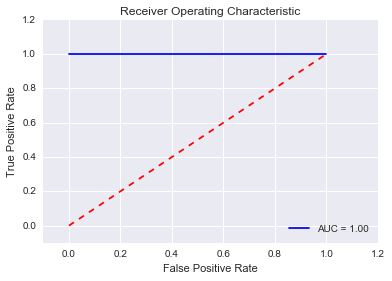

In [104]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

actual = [1,1,1,0,0,0]
predictions = [0.9,0.9,0.9,0.1,0.1,0.1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [106]:
knn_ens = KNeighborsClassifier(n_neighbors = 11).fit(X_train_knn, y_train_knn)
print 'done'
logistic_ens = LogisticRegression().fit(X_log, y_log)
print 'done'
svm_ens = SVC(kernel='rbf', C=1, gamma=0.1, probability=True).fit(X_train_svm, y_train_svm)
print 'done'
xgb_ens = xgboost.XGBClassifier(learning_rate=.1, n_estimators=300,  min_child_weight=1,
                                gamma=0, seed=8, colsample_bytree=.4, max_depth=4,
                                subsample=.5).fit(X_train_svm, y_train_svm)





done
done
done


In [116]:
svm_preds = svm_ens.predict_proba(X_test)[:,1]
knn_preds = knn_ens.predict_proba(X_test)[:,1]
log_preds = logistic_ens.predict_proba(X_test)[:,1]
xg_preds = xgb_ens.predict_proba(X_test)[:,1]

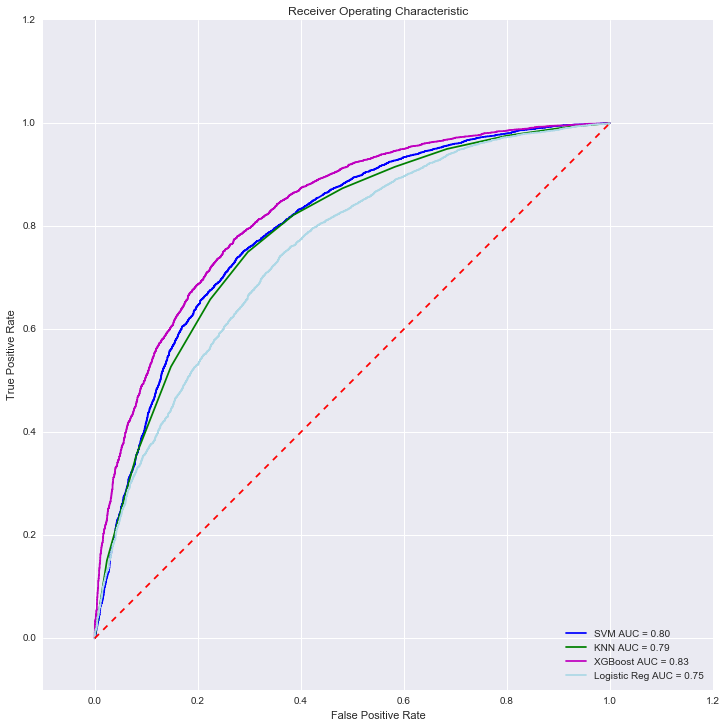

In [138]:
actual = y_test
fpr, tpr, thresholds = roc_curve(actual, svm_preds)
roc_auc = auc(fpr, tpr)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(actual, knn_preds)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(actual, xg_preds)
roc_auc_xg = auc(fpr_xg, tpr_xg)

fpr_log, tpr_log, thresholds_log = roc_curve(actual, log_preds)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(12,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='SVM AUC = %0.2f'% roc_auc)
plt.plot(fpr_knn, tpr_knn, 'g',
label='KNN AUC = %0.2f'% roc_auc_knn)
plt.plot(fpr_xg, tpr_xg, 'm',
label='XGBoost AUC = %0.2f'% roc_auc_xg)
plt.plot(fpr_log, tpr_log, 'lightblue',
label='Logistic Reg AUC = %0.2f'% roc_auc_log)

plt.legend(loc='lower right')


plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [155]:
100*len(df[df.avg_surge >= 2])/float(len(df))

1.456

(0, 10)

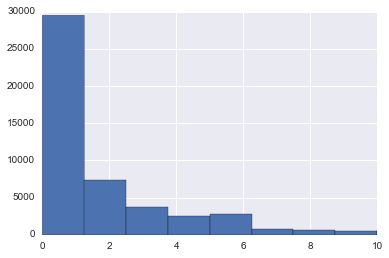

In [159]:
df.trips_in_first_30_days.hist(bins=100)
plt.xlim((0,10))

In [160]:
df.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'last_trip_date', u'signup_date', u'surge_pct',
       u'trips_in_first_30_days', u'luxury_car_user', u'weekday_pct',
       u'days_since_last_trip', u'churn', u'days_since_signup', u'isAndroid',
       u'Astapor', u'King's Landing', u'Winterfell'],
      dtype='object')